# Saturn aliens - EDA for Saturn beta logs
### Maria Silva, July 2022

In this notebook, we explore a day of logs extracted from Saturn. It is important to note that these logs correspond to requests made by the Saturn team using a small group of legitimate ARC nodes for testing purposes. Therefore, we will not find any fraudulent requests. In addition, the data distribution is expected to change when Saturn launches and we start receiving requests from real users.

**Note on reproducibility:**

To reproduce this notebook, you will need to run a SQL query to extract the corresponding data. The query is the following:

```sql
SELECT * 
FROM bandwidth_logs
WHERE start_time BETWEEN TIMESTAMP '2022-07-05 00:00:00' AND TIMESTAMP '2022-07-05 23:59:59'
```

If you are not sure how to access this data, reach out to maria.silva@protocol.ai

After getting the data into a csv file, make sure you update the path to read the file into a pandas DataFrame.

***


In [1]:
import os
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
def compute_gini(x):
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

# 0. Load data

In [3]:
data_file = os.path.abspath("../../../../Data/Saturn/bandwidth_logs_jul_05.csv")

raw_df = pd.read_csv(data_file)
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3247680 entries, 0 to 3247679
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   node_id               object 
 1   client_id             object 
 2   request_id            object 
 3   cid                   object 
 4   num_bytes_sent        int64  
 5   request_byte_offset   int64  
 6   start_time            object 
 7   request_duration_sec  float64
 8   cache_hit             object 
 9   user_agent            object 
 10  client_address        object 
 11  referrer              object 
dtypes: float64(1), int64(2), object(9)
memory usage: 297.3+ MB


In [4]:
raw_df.isna().sum()

node_id                  0
client_id                0
request_id               0
cid                      0
num_bytes_sent           0
request_byte_offset      0
start_time               0
request_duration_sec     0
cache_hit                0
user_agent              36
client_address           0
referrer                23
dtype: int64

In [5]:
raw_df.head(1).T

,0
node_id,718fd64e-272a-405d-891e-fcf23ce0dd28
client_id,ff257d68-49f0-46c1-bc3c-5f66049a32e1
request_id,770eb68121874abd19f24d6d78db7e3c
cid,QmYbwUDpY4FApjoCMvb9rzow5iUHn4V17hA2xVLcCytwja
num_bytes_sent,662159
request_byte_offset,0
start_time,2022-07-05 00:00:00+00
request_duration_sec,0.915
cache_hit,t
user_agent,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...


In [6]:
df = raw_df.dropna()
df["start_time"] = pd.to_datetime(df["start_time"])
df["mb_sent"] = df["num_bytes_sent"]/(2**20)

In [7]:
df["start_time"].agg(["min", "max"])

min   2022-07-05 00:00:00+00:00
max   2022-07-05 23:59:59+00:00
Name: start_time, dtype: datetime64[ns, UTC]

# 1. Station nodes & requests

In [8]:
unique_nodes = df["node_id"].unique()
len(unique_nodes)

36

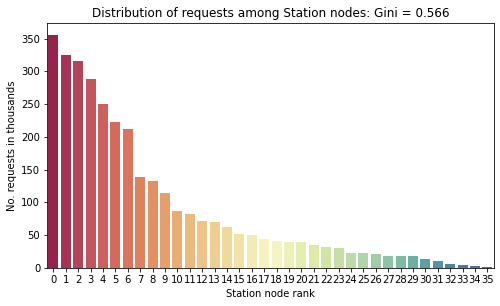

In [9]:
requests_per_node = df.groupby("node_id")["request_id"].nunique().sort_values(ascending=False)/1000
requests_per_node = requests_per_node.reset_index().reset_index()
gini = np.round(compute_gini(requests_per_node["request_id"].values), 3)

fig, ax = plt.subplots(figsize=(8,4.5))
sns.barplot(x="index", y="request_id", data=requests_per_node, palette="Spectral", ax=ax)
plt.xlabel("Station node rank")
plt.ylabel("No. requests in thousands")
plt.title(f"Distribution of requests among Station nodes: Gini = {gini}")
plt.show()

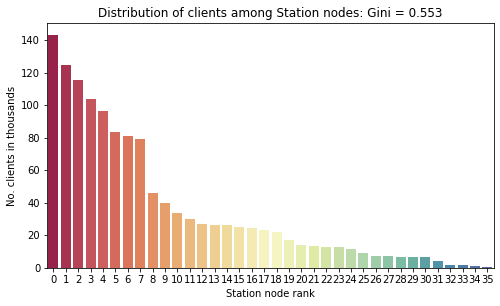

In [10]:
clients_per_node = df.groupby("node_id")["client_id"].nunique().sort_values(ascending=False)/1000
clients_per_node = clients_per_node.reset_index().reset_index()
gini = np.round(compute_gini(clients_per_node["client_id"].values), 3)

fig, ax = plt.subplots(figsize=(8,4.5))
sns.barplot(x="index", y="client_id", data=clients_per_node, palette="Spectral", ax=ax)
plt.xlabel("Station node rank")
plt.ylabel("No. clients in thousands")
plt.title(f"Distribution of clients among Station nodes: Gini = {gini}")
plt.show()

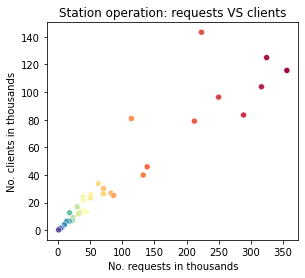

In [11]:
join_per_node = clients_per_node.drop(columns=["index"]).merge(requests_per_node, on="node_id")

fig, ax = plt.subplots(figsize=(4.5,4))
sns.scatterplot(x="request_id", y="client_id",hue="index", data=join_per_node, 
                palette="Spectral", ax=ax, legend = False)
plt.xlabel("No. requests in thousands")
plt.ylabel("No. clients in thousands")
plt.title(f"Station operation: requests VS clients")

plt.show()

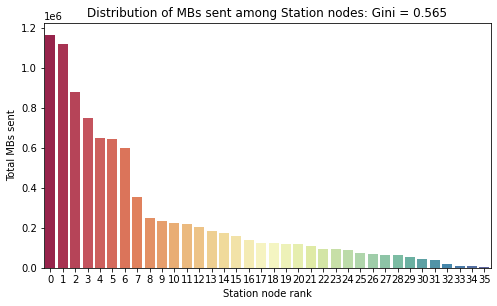

In [12]:
bandwidth_per_node = df.groupby("node_id")["mb_sent"].sum().sort_values(ascending=False)
bandwidth_per_node = bandwidth_per_node.reset_index().reset_index()
gini = np.round(compute_gini(bandwidth_per_node["mb_sent"].values), 3)

fig, ax = plt.subplots(figsize=(8,4.5))
sns.barplot(x="index", y="mb_sent", data=bandwidth_per_node, palette="Spectral", ax=ax)
plt.xlabel("Station node rank")
plt.ylabel("Total MBs sent")
plt.title(f"Distribution of MBs sent among Station nodes: Gini = {gini}")
plt.show()

# 2. Clients, user agents & referrers

Notes:

- The referrer is the website domain from which the request was submitted.
- If request comes from an L1/L2 node, the `clientId` is the node’s `nodeId`

In [13]:
len(df["client_id"].unique())

1250277

In [14]:
len(df["referrer"].unique())

84790

In [15]:
len(df["user_agent"].unique())

82831

In [16]:
# Do we see station nodes submitting requests?

sum(df["client_id"].isin(unique_nodes))

0

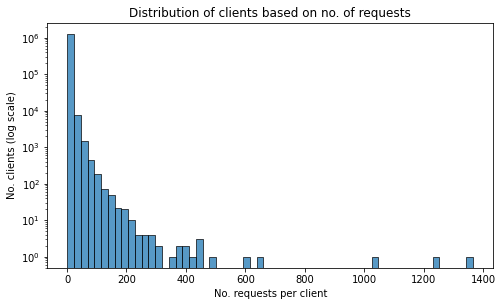

In [17]:
requests_per_client = df.groupby("client_id")["request_id"].nunique()

fig, ax = plt.subplots(figsize=(8,4.5))
sns.histplot(data=requests_per_client, palette="Spectral", ax=ax, bins=60)
ax.set_yscale('log')
plt.xlabel("No. requests per client")
plt.ylabel("No. clients (log scale)")
plt.title(f"Distribution of clients based on no. of requests")
plt.show()

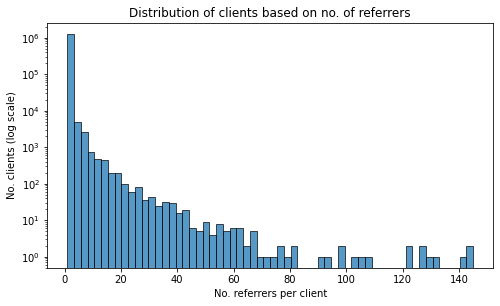

In [18]:
referrers_per_client = df.groupby("client_id")["referrer"].nunique()

fig, ax = plt.subplots(figsize=(8,4.5))
sns.histplot(data=referrers_per_client, palette="Spectral", ax=ax, bins=60)
ax.set_yscale('log')
plt.xlabel("No. referrers per client")
plt.ylabel("No. clients (log scale)")
plt.title(f"Distribution of clients based on no. of referrers")
plt.show()

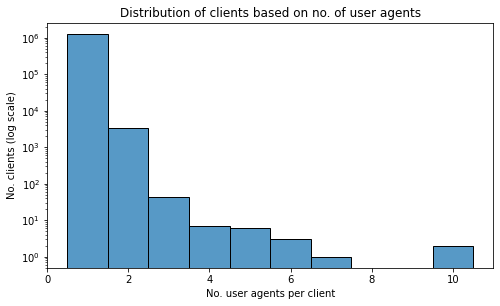

In [19]:
agents_per_client = df.groupby("client_id")["user_agent"].nunique()

fig, ax = plt.subplots(figsize=(8,4.5))
sns.histplot(data=agents_per_client, palette="Spectral", ax=ax, bins=10, discrete=True)
ax.set_yscale('log')
plt.xlabel("No. user agents per client")
plt.ylabel("No. clients (log scale)")
plt.title(f"Distribution of clients based on no. of user agents")
plt.show()

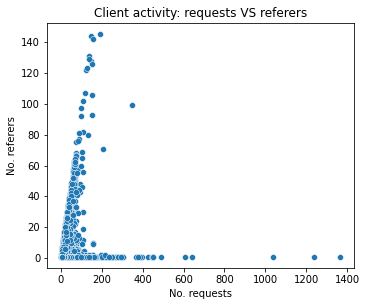

In [20]:
join_per_client = pd.DataFrame([requests_per_client, referrers_per_client]).T.reset_index()

fig, ax = plt.subplots(figsize=(5.5,4.5))
sns.scatterplot(x="request_id", y="referrer", data=join_per_client, ax=ax, legend = False)
plt.xlabel("No. requests")
plt.ylabel("No. referers")
plt.title(f"Client activity: requests VS referers")

plt.show()

# 3. Content - cid and bytes

In [21]:
len(df["cid"].unique())

8795

In [22]:
cid_df = (
    df.groupby("cid")
    ["mb_sent"]
    .agg(["mean", "std", "count"])
    .sort_values("mean", ascending=False)
    .reset_index()
)
cid_df.columns = ["cid", "avg_mb", "std_mb", "requests"]
cid_df["cv_mb"] = cid_df["std_mb"]/cid_df["avg_mb"]
cid_df.head()

,cid,avg_mb,std_mb,requests,cv_mb
0,QmeCjHXxDdMvYU635iCNmW9HwXFacJoeN5QnwdJDiyAX63,149.809798,157.501557,35,1.051344
1,bafybeihcz2mhlvvemovsu2mhxnuferduvilpdj47lzbwa...,141.485878,143.555201,70,1.014626
2,QmYSVYVuQQzTg9rGNkQv8Co7U9L9Hqc9JzviDdg9bovp6h,132.308400,130.544852,354,0.986671
3,Qmas8SGoBzBi4J888SUjoPf7xkh4yGmCzdnrYWoC9B2p8S,131.276787,130.270446,205,0.992334
4,Qmbi9MQ2SVhzmLtyTf666s22WrM5eZ3nZmrxzmX7Gajpks,128.965466,132.636050,426,1.028462


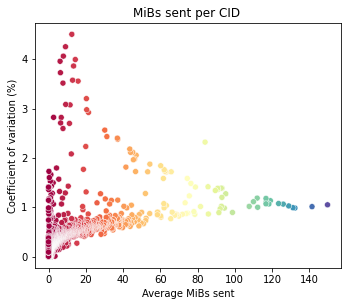

In [23]:
fig, ax = plt.subplots(figsize=(5.5,4.5))
sns.scatterplot(x="avg_mb", y="cv_mb",hue="avg_mb", data=cid_df, 
                palette="Spectral", ax=ax, legend=False)
plt.xlabel("Average MiBs sent")
plt.ylabel("Coefficient of variation (%)")
plt.title(f"MiBs sent per CID ")

plt.show()

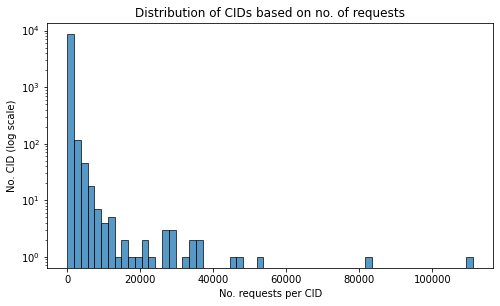

In [24]:
fig, ax = plt.subplots(figsize=(8,4.5))
sns.histplot(x="requests", data=cid_df, palette="Spectral", ax=ax, bins=60)
ax.set_yscale('log')
plt.xlabel("No. requests per CID")
plt.ylabel("No. CID (log scale)")
plt.title(f"Distribution of CIDs based on no. of requests")
plt.show()

# 4. Station service - duration & cache usage

In [25]:
duration_cache_df = (
    df
    .groupby("cache_hit")
    ["request_duration_sec"]
    .agg(["mean", "std", "count"])
    .reset_index()
)
duration_cache_df["cv"] = duration_cache_df["std"]/duration_cache_df["mean"]
duration_cache_df

,cache_hit,mean,std,count,cv
0,f,117.718943,710.663217,172489,6.036949
1,t,3.567216,25.869310,3075132,7.251960


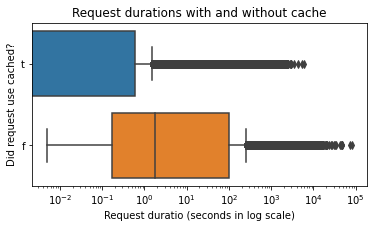

In [26]:
fig, ax = plt.subplots(figsize=(6,3))
sns.boxplot(y="cache_hit", x="request_duration_sec", data=df, ax=ax, orient="h")
ax.set_xscale('log')

plt.xlabel("Request duratio (seconds in log scale)")
plt.ylabel("Did request use cached?")
plt.title(f"Request durations with and without cache")

plt.show()

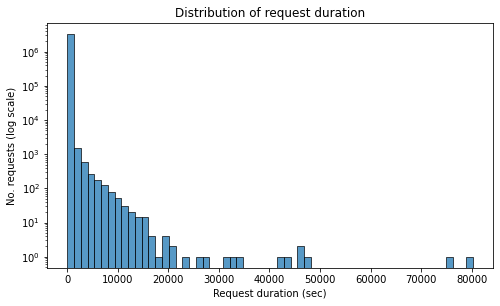

In [32]:
fig, ax = plt.subplots(figsize=(8,4.5))
sns.histplot(x="request_duration_sec", data=df, palette="Spectral", ax=ax, bins=60)
ax.set_yscale('log')
plt.xlabel("Request duration (sec)")
plt.ylabel("No. requests (log scale)")
plt.title(f"Distribution of request duration")
plt.show()